In [1]:
library(rjags)
library(runjags)
library(R2jags)

Loading required package: coda

Linked to JAGS 4.3.0

Loaded modules: basemod,bugs


Attaching package: ‘R2jags’


The following object is masked from ‘package:coda’:

    traceplot




In [2]:
tot_vaccine <- 14134
tot_placebo <- 14073
patient <- c(rep("Vaccine", tot_vaccine),
             rep("Placebo", tot_placebo))
# Number of patients tested postive after RCT:
pos_vaccine <- 11
pos_placebo <- 185
tested   <- c(rep("Pos", pos_vaccine),
              rep("Neg", tot_vaccine - pos_vaccine),
              rep("Pos", pos_placebo),
              rep("Neg", tot_placebo - pos_placebo))
moderna.tb <- tibble::tibble(tested = tested, patient=patient)
table(moderna.tb[[2]], moderna.tb[[1]])

         
            Neg   Pos
  Placebo 13888   185
  Vaccine 14123    11

In [3]:
dataList = list(
    tested = ifelse(moderna.tb$tested == "Neg", 0, 1),
    patient = as.integer(factor(moderna.tb$patient)),
    Ntot = nrow(moderna.tb) ,
    Nclass = nlevels(factor(moderna.tb$patient))
)

In [4]:
modelString <- "  
  model {
    for ( i in 1:Ntot ) {
      tested[i] ~ dbern( theta[patient[i]] )
    }
  for ( k in 1:Nclass ) {
    theta[k] ~ dbeta(3 , 100)    
    }
  theta[3] = (theta[1]-theta[2])/theta[1] * 100
  }"
writeLines(modelString , con="jags_Moderna_model.txt")

In [5]:
moderna_chains <- run.jags(modelString ,
                          sample = 15000,
                          n.chains = 4,
                          method = "parallel",
                          monitor = "theta",
                          data = dataList)

Warning message:
“No initial values were provided - JAGS will use the same initial values for all chains”
Warning message:
“You attempted to start parallel chains without setting different PRNG for each chain, which is not recommended.  Different .RNG.name values have been added to each set of initial values.”


Calling 4 simulations using the parallel method...
Following the progress of chain 1 (the program will wait for all chains
to finish before continuing):
Welcome to JAGS 4.3.0 on Tue Jun 22 13:12:47 2021
JAGS is free software and comes with ABSOLUTELY NO WARRANTY
Loading module: basemod: ok
Loading module: bugs: ok
. . Reading data file data.txt
. Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 28207
   Unobserved stochastic nodes: 2
   Total graph size: 56423
. Reading parameter file inits1.txt
. Initializing model
. Adaptation skipped: model is not in adaptive mode.
. Updating 4000
-------------------------------------------------| 4000
************************************************** 100%
. . Updating 15000
-------------------------------------------------| 15000
************************************************** 100%
. . . . Updating 0
. Deleting model
. 
All chains have finished
Note: the model did not r

In [6]:
summary(moderna_chains)
add.summary(moderna_chains)

,Lower95,Median,Upper95,Mean,SD,Mode,MCerr,MC%ofSD,SSeff,AC.10,psrf
theta[1],1.14300e-02,0.013237450,0.01517530,1.326378e-02,0.0009623011,NA,4.811506e-06,0.5,40000,-0.008074206,1.000067
theta[2],4.87892e-04,0.000959459,0.00149397,9.829581e-04,0.0002624497,NA,1.286191e-06,0.5,41637,0.004677950,1.000130
theta[3],8.84800e+01,92.756400000,96.34370000,9.255014e+01,2.0666666134,NA,1.013885e-02,0.5,41549,0.003416930,1.000261


Calculating summary statistics...
Calculating the Gelman-Rubin statistic for 3 variables....



JAGS model summary statistics from 60000 samples (chains = 4; adapt+burnin = 5000):
                                                                             
            Lower95     Median  Upper95       Mean         SD Mode      MCerr
theta[1]   0.011427   0.013238 0.015178   0.013264 0.00096257   -- 3.9544e-06
theta[2] 0.00048963 0.00095921 0.001494 0.00098318 0.00026282   -- 1.0637e-06
theta[3]      88.46     92.752   96.349     92.548       2.07   --  0.0083846
                                        
         MC%ofSD SSeff      AC.10   psrf
theta[1]     0.4 59253 -0.0080742      1
theta[2]     0.4 61049  0.0046779 1.0001
theta[3]     0.4 60950  0.0034169 1.0001

Total time taken: 1.2 minutes


In [7]:
library(tidybayes)
library(dplyr)
library(coda)
library(rstanarm)
library(plotrix)
library(dupiR)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: Rcpp

This is rstanarm version 2.21.1

- See https://mc-stan.org/rstanarm/articles/priors for changes to default priors!

- Default priors may change, so it's safest to specify priors, even if equivalent to the defaults.

- For execution on a local, multicore CPU with excess RAM we recommend calling

  options(mc.cores = parallel::detectCores())



In [8]:
moderna_res    <- tidybayes::tidy_draws(moderna_chains) %>%
                 select('theta[1]':'theta[2]') %>%
                 rename(Placebo = 'theta[1]', Vaccine = 'theta[2]') %>%
                 mutate(diff_rate = (Placebo - Vaccine) / Placebo * 100,
                        Placebo_perc = Placebo * 100,
                        Vaccine_perc = Vaccine * 100)

In [9]:
moderna.mcmc <- as.mcmc(moderna_res)
moderna.data <- as.data.frame(moderna.mcmc)

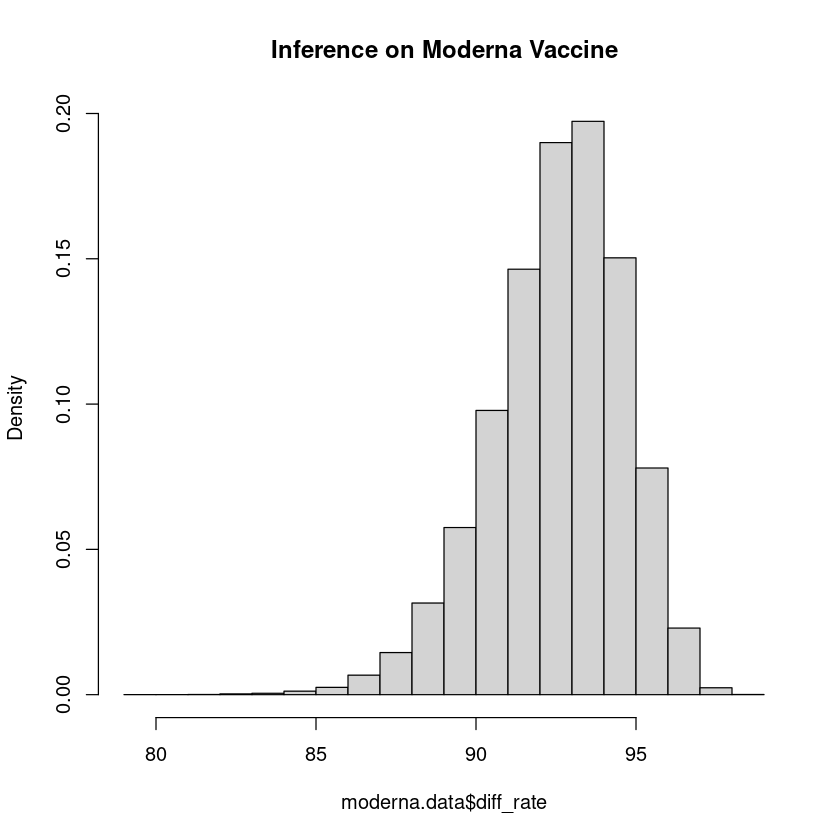

In [10]:
hist(moderna.data$diff_rate,freq=FALSE,main='Inference on Moderna Vaccine')

In [11]:
bayestestR::describe_posterior(moderna.data$diff_rate,
                               ci=0.95,
                               test=c("p_direction"),
                               centrality="map")

,Parameter,MAP,CI,CI_low,CI_high,pd
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Posterior,93.30442,0.95,88.46013,96.34879,1


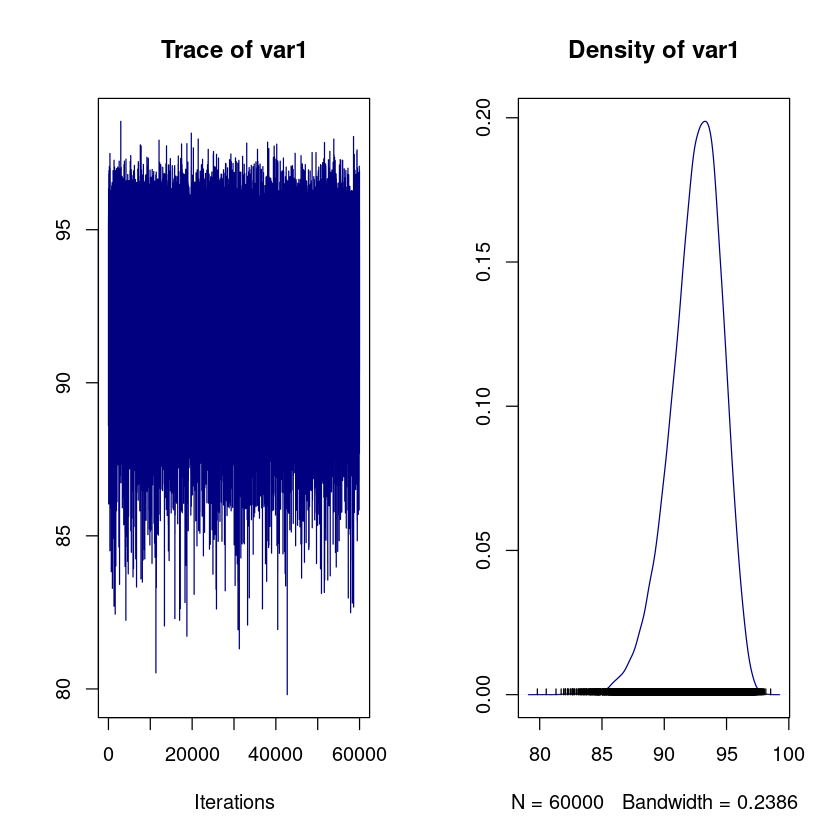

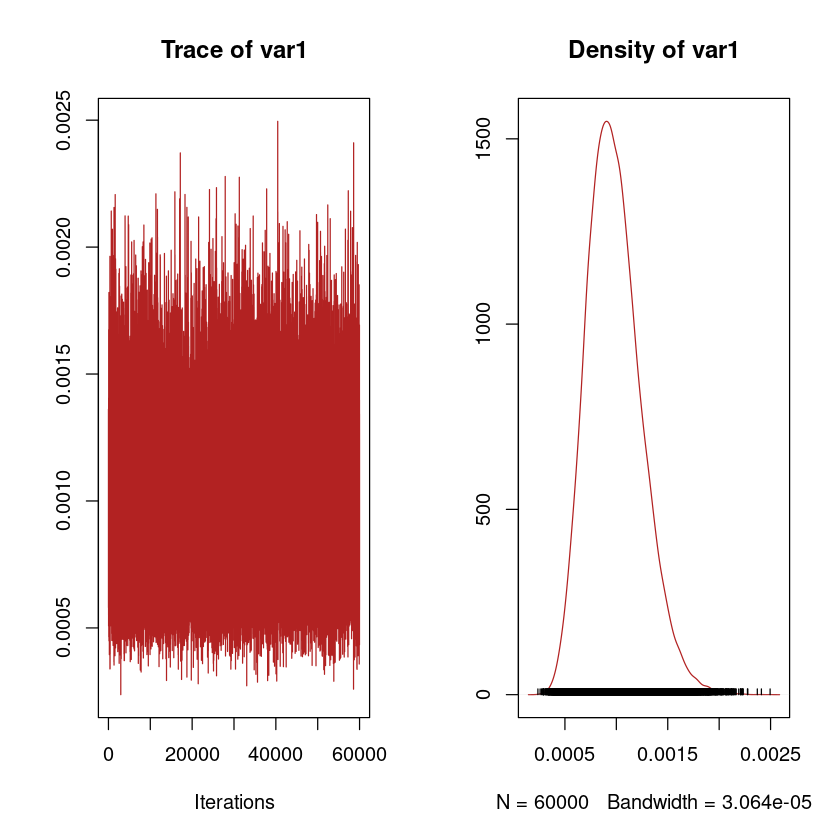

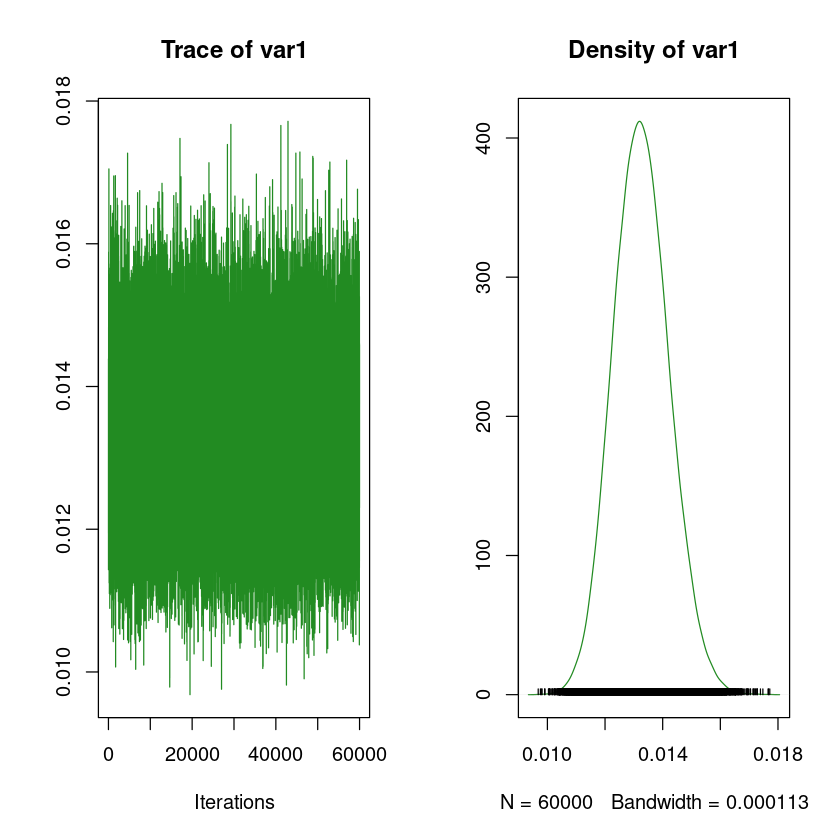

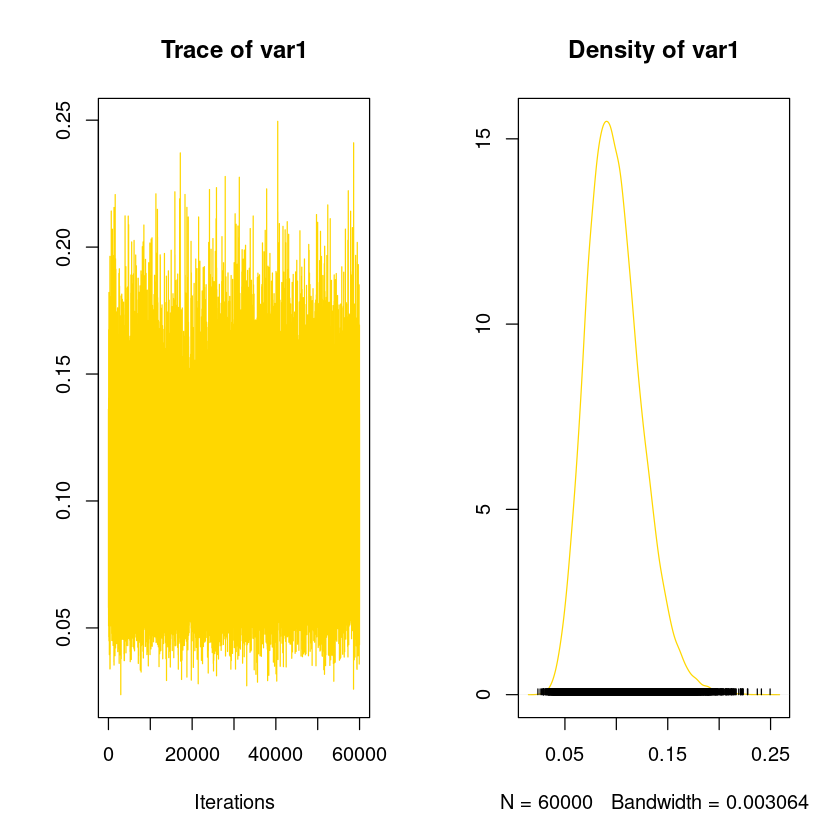

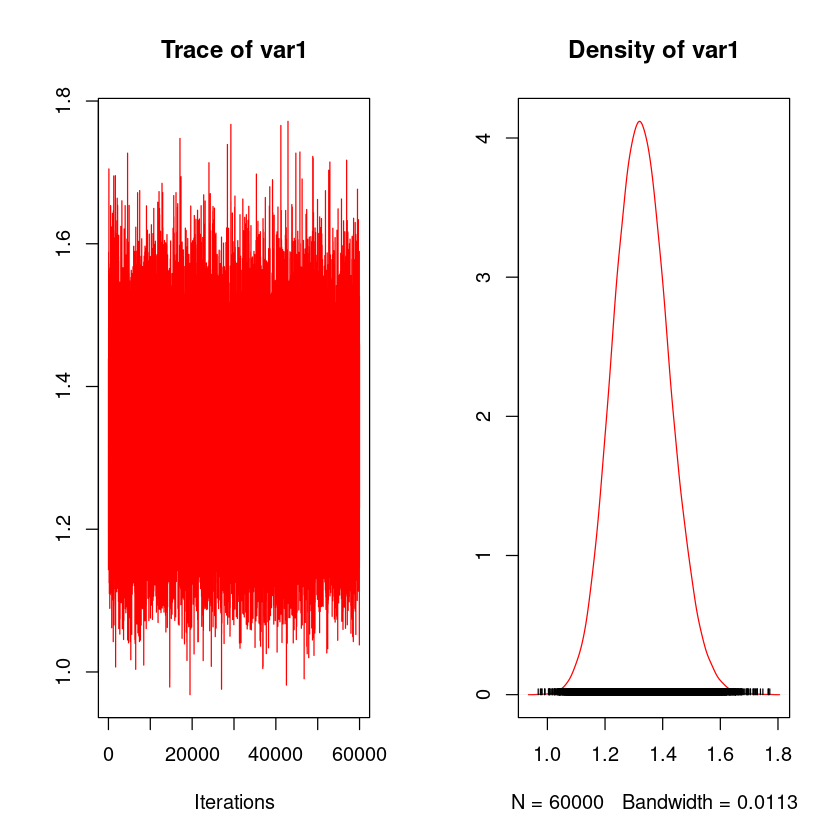

In [12]:
plot(moderna.mcmc[,'diff_rate'],col='navy')
plot(moderna.mcmc[,'Vaccine'],col='firebrick')
plot(moderna.mcmc[,'Placebo'],col='forestgreen')
plot(moderna.mcmc[,'Vaccine_perc'],col='gold')
plot(moderna.mcmc[,'Placebo_perc'],col='red')